# Geo-Experiment Playground

This notebook provides an interactive environment for experimenting with the geo-experiment evaluation framework.

## Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import our modules
from data_simulation.generators import SimpleNullGenerator, DataConfig
from assignment.methods import RandomAssignment, KMeansEmbeddingAssignment, PrognosticScoreAssignment, EmbeddingBasedAssignment, HybridEmbeddingAssignment
from assignment.spatial_utils import add_spectral_spatial_embedding
from assignment.stratified_utils import stratified_assignment_within_clusters, evaluate_cluster_balance, print_balance_summary
from reporting.models import MeanMatchingModel, GBRModel, TBRModel, SyntheticControlModel
from reporting import STGCNReportingModel
from evaluation.metrics import EvaluationRunner, EvaluationConfig
from diagnostics.plots import DiagnosticPlotter
from pipeline.runner import ExperimentRunner
from pipeline.config import ExperimentConfig

# Set style
plt.style.use('default')
sns.set_palette('husl')

print("✅ All modules imported successfully!")
print("📊 Available assignment methods:")
print("  • RandomAssignment: Simple random assignment")
print("  • KMeansEmbeddingAssignment: K-means clustering on features")
print("  • PrognosticScoreAssignment: OLS-based prognostic scoring")
print("  • EmbeddingBasedAssignment: General embedding approach (neural + spatial)")
print("  • HybridEmbeddingAssignment: Semi-supervised prediction-aware assignment")
print("\n🧠 Available reporting models:")
print("  • MeanMatchingModel: Simple control group mean")
print("  • GBRModel: Geo-Based Regression")
print("  • TBRModel: Time-Based Regression")
print("  • SyntheticControlModel: Classical synthetic control")
print("  • STGCNReportingModel: Spatio-Temporal Graph Neural Network")

✅ All modules imported successfully!
📊 Available assignment methods:
  • RandomAssignment: Simple random assignment
  • KMeansEmbeddingAssignment: K-means clustering on features
  • PrognosticScoreAssignment: OLS-based prognostic scoring
  • EmbeddingBasedAssignment: General embedding approach (neural + spatial)
  • HybridEmbeddingAssignment: Semi-supervised prediction-aware assignment

🧠 Available reporting models:
  • MeanMatchingModel: Simple control group mean
  • GBRModel: Geo-Based Regression
  • TBRModel: Time-Based Regression
  • SyntheticControlModel: Classical synthetic control
  • STGCNReportingModel: Spatio-Temporal Graph Neural Network


## Quick Start: Single Experiment

Let's start with a simple single experiment to understand the framework.

In [ ]:
# Create a simple configuration
config = ExperimentConfig(
    n_geos=20,
    n_days=60,
    pre_period_days=40,
    eval_period_days=20,
    seed=42
)

# Run a single experiment
runner = ExperimentRunner(config)
results = runner.run_single_experiment(show_plots=True)

print(f"\n📊 Single Experiment Results:")
print(f"iROAS Estimate: {results['iroas_estimate']:.4f}")
print(f"95% CI: [{results['iroas_ci'][0]:.4f}, {results['iroas_ci'][1]:.4f}]")
print(f"CI Width: {results['ci_width']:.4f}")
print(f"Significant: {results['significant']}")

## Full Evaluation Example

Now let's run a complete evaluation across multiple simulations to see how the method performs statistically.

In [ ]:
# Run a full evaluation with the same configuration
# Using smaller numbers for faster execution in the playground
full_eval_config = ExperimentConfig(
    n_geos=30,           # Moderate number of geos
    n_days=60,           # 60 days total
    pre_period_days=40,  # 40 days for training
    eval_period_days=20, # 20 days for evaluation
    n_simulations=50,    # 50 simulations (increase for more robust results)
    n_bootstrap=200,     # 200 bootstrap samples per simulation
    seed=42
)

print("🔄 Running full evaluation (this may take a minute)...")
print(f"Configuration: {full_eval_config.n_simulations} simulations, {full_eval_config.n_geos} geos each")

# Create runner and run evaluation
eval_runner = ExperimentRunner(full_eval_config)

# Add all reporting models for comparison
eval_runner.add_reporting_method('GBR', GBRModel())
eval_runner.add_reporting_method('TBR', TBRModel())
eval_runner.add_reporting_method('SCM', SyntheticControlModel())

detailed_results, summary_results = eval_runner.run_full_evaluation(verbose=True)

print("\n📈 Summary Results:")
print(summary_results)

# Create visualization
print("\n📊 Creating results visualization...")
fig = eval_runner.plot_results(detailed_results)
plt.show()

# Additional insights
print(f"\n🔍 Key Insights:")
print(f"• Average iROAS estimate: {detailed_results['iroas_estimate'].mean():.4f}")
print(f"• Standard deviation of estimates: {detailed_results['iroas_estimate'].std():.4f}")
print(f"• False positive rate: {summary_results['false_positive_rate'].iloc[0]:.3f} (should be ~0.05)")
print(f"• Coverage rate: {summary_results['coverage_rate'].iloc[0]:.3f} (should be ~0.95)")
print(f"• Mean CI width: {summary_results['mean_ci_width'].iloc[0]:.4f}")

# Show distribution of estimates
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.hist(detailed_results['iroas_estimate'], bins=20, alpha=0.7, edgecolor='black')
plt.axvline(0, color='red', linestyle='--', label='True iROAS (0)')
plt.xlabel('iROAS Estimate')
plt.ylabel('Frequency')
plt.title('Distribution of iROAS Estimates')
plt.legend()

plt.subplot(1, 2, 2)
plt.hist(detailed_results['ci_width'], bins=20, alpha=0.7, edgecolor='black', color='orange')
plt.xlabel('Confidence Interval Width')
plt.ylabel('Frequency')
plt.title('Distribution of CI Widths')

plt.tight_layout()
plt.show()

## Data Generation Experiments

Let's experiment with different data generation parameters.

In [ ]:
# Generate data with different noise levels
low_noise_config = DataConfig(
    n_geos=30,
    n_days=90,
    daily_sales_noise=100,  # Low noise
    seed=123
)

high_noise_config = DataConfig(
    n_geos=30,
    n_days=90,
    daily_sales_noise=1000,  # High noise
    seed=123
)

# Generate both datasets
low_noise_gen = SimpleNullGenerator(low_noise_config)
high_noise_gen = SimpleNullGenerator(high_noise_config)

panel_low, features_low = low_noise_gen.generate()
panel_high, features_high = high_noise_gen.generate()

# Compare variability
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot time series for first geo
geo_low = panel_low[panel_low['geo'] == 'geo_000']
geo_high = panel_high[panel_high['geo'] == 'geo_000']

axes[0].plot(geo_low['date'], geo_low['sales'], label='Low Noise', alpha=0.8)
axes[0].plot(geo_high['date'], geo_high['sales'], label='High Noise', alpha=0.8)
axes[0].set_title('Sales Time Series Comparison (geo_000)')
axes[0].set_ylabel('Sales')
axes[0].legend()
axes[0].tick_params(axis='x', rotation=45)

# Plot distributions
axes[1].hist(panel_low['sales'], alpha=0.6, label='Low Noise', bins=30)
axes[1].hist(panel_high['sales'], alpha=0.6, label='High Noise', bins=30)
axes[1].set_title('Sales Distribution Comparison')
axes[1].set_xlabel('Sales')
axes[1].set_ylabel('Frequency')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Low noise std: {panel_low['sales'].std():.2f}")
print(f"High noise std: {panel_high['sales'].std():.2f}")

## Assignment Method Testing

Test different assignment strategies and their balance.

In [ ]:
# Comprehensive Assignment Method Comparison
print("📊 COMPREHENSIVE ASSIGNMENT METHOD COMPARISON")
print("="*80)

# Generate test data with all necessary features
np.random.seed(42)
test_geo_features = pd.DataFrame({
    'geo': [f'geo_{i:03d}' for i in range(40)],
    'base_sales': np.random.normal(12000, 4000, 40),
    'base_spend': np.random.normal(6000, 2000, 40),
    'covariate': np.random.normal(0, 1.5, 40),
    'xy1': np.random.uniform(0, 100, 40),  # Spatial coordinates
    'xy2': np.random.uniform(0, 100, 40)
})

# Create panel data for time-series methods
dates = pd.date_range('2024-01-01', periods=60)
test_panel_data = []
for _, geo_row in test_geo_features.iterrows():
    base_sales = geo_row['base_sales']
    trend = np.random.normal(0, 50)
    for day_idx, date in enumerate(dates):
        sales = (base_sales + trend * day_idx + np.random.normal(0, 500) + 
                300 * np.sin(day_idx * 2 * np.pi / 7))  # Weekly seasonality
        test_panel_data.append({
            'geo': geo_row['geo'],
            'date': date,
            'sales': max(sales, 1000),
            'spend_dollars': np.random.normal(5000, 1000)
        })
test_panel_df = pd.DataFrame(test_panel_data)

print(f"Dataset: {len(test_geo_features)} geos with {len(test_panel_df)} panel observations")

# Define all available assignment methods
assignment_methods = {
    'Random': {
        'method': RandomAssignment(),
        'description': 'Simple random assignment (baseline)',
        'requires_panel': False,
        'requires_spatial': False
    },
    'K-Means': {
        'method': KMeansEmbeddingAssignment(n_clusters=5),
        'description': 'K-means clustering on standardized features',
        'requires_panel': False,
        'requires_spatial': False
    },
    'Prognostic Score': {
        'method': PrognosticScoreAssignment(n_strata=5),
        'description': 'OLS-based prognostic scoring with stratification',
        'requires_panel': True,
        'requires_spatial': False
    },
    'Embedding-Based': {
        'method': EmbeddingBasedAssignment(n_clusters=5, neural_epochs=15),
        'description': 'Neural + spectral spatial embeddings',
        'requires_panel': False,
        'requires_spatial': True
    },
    'Hybrid Embedding': {
        'method': HybridEmbeddingAssignment(n_clusters=5, neural_epochs=15),
        'description': 'Semi-supervised: reconstruction + prediction loss',
        'requires_panel': True,
        'requires_spatial': True
    }
}

# Create comprehensive comparison visualization
fig, axes = plt.subplots(3, len(assignment_methods), figsize=(25, 15))

print("\n" + "="*80)
print("🎯 ASSIGNMENT METHOD DETAILED COMPARISON")
print("="*80)

balance_summary = {}
for i, (method_name, method_info) in enumerate(assignment_methods.items()):
    print(f"\n🔹 {method_name.upper()}:")
    print(f"   {method_info['description']}")
    print("-" * 60)
    
    try:
        # Create assignment based on method requirements
        if method_info['requires_panel'] and method_info['requires_spatial']:
            # Hybrid embedding needs both
            assignment_df = method_info['method'].assign(
                test_geo_features, panel_data=test_panel_df, seed=42
            )
        elif method_info['requires_panel']:
            # Prognostic score needs panel data
            assignment_df = method_info['method'].assign(
                test_geo_features[['geo', 'base_sales', 'base_spend', 'covariate']], 
                panel_data=test_panel_df, seed=42
            )
        elif method_info['requires_spatial']:
            # Embedding-based needs spatial coordinates
            assignment_df = method_info['method'].assign(test_geo_features, seed=42)
        else:
            # Random and K-means work with basic features
            assignment_df = method_info['method'].assign(
                test_geo_features[['geo', 'base_sales', 'base_spend', 'covariate']], seed=42
            )
        
        # Merge for analysis
        if method_info['requires_spatial']:
            analysis_features = test_geo_features
        else:
            analysis_features = test_geo_features[['geo', 'base_sales', 'base_spend', 'covariate']]
        
        merged = analysis_features.merge(assignment_df, on='geo')
        
        # Print assignment summary
        treatment_count = (assignment_df['assignment'] == 'treatment').sum()
        control_count = (assignment_df['assignment'] == 'control').sum()
        
        print(f"   Assignment: {treatment_count} treatment, {control_count} control")
        
        # Handle cluster information
        if 'cluster' not in assignment_df.columns:
            assignment_df = assignment_df.copy()
            assignment_df['cluster'] = 0  # Single cluster for methods without clustering
            print(f"   Structure: No clustering (all geos treated as single group)")
        else:
            n_clusters = len(assignment_df['cluster'].unique())
            cluster_dist = assignment_df['cluster'].value_counts().sort_index()
            print(f"   Structure: {n_clusters} clusters/strata")
            print(f"   Distribution: {dict(cluster_dist)}")
        
        # Evaluate balance
        feature_cols = ['base_sales', 'base_spend', 'covariate']
        balance_df = evaluate_cluster_balance(analysis_features, assignment_df, feature_cols)
        
        # Calculate balance metrics
        overall_balance = balance_df[balance_df['cluster'] == 'Overall']
        avg_smd = overall_balance['standardized_diff'].mean()
        max_smd = overall_balance['standardized_diff'].max()
        
        balance_summary[method_name] = {
            'avg_smd': avg_smd,
            'max_smd': max_smd,
            'treatment_count': treatment_count,
            'control_count': control_count,
            'n_clusters': len(assignment_df['cluster'].unique())
        }
        
        # Print balance summary
        print(f"   Balance: Avg SMD = {avg_smd:.3f}, Max SMD = {max_smd:.3f}")
        balance_quality = ("Excellent" if avg_smd < 0.05 else 
                          "Good" if avg_smd < 0.1 else 
                          "Moderate" if avg_smd < 0.2 else "Poor")
        print(f"   Quality: {balance_quality} ({'✅' if avg_smd < 0.1 else '⚠️' if avg_smd < 0.2 else '❌'})")
        
        # Visualization 1: Sales balance
        sns.boxplot(data=merged, x='assignment', y='base_sales', ax=axes[0, i])
        axes[0, i].set_title(f'{method_name}\nSales Balance')
        axes[0, i].set_ylabel('Base Sales' if i == 0 else '')
        
        # Visualization 2: Covariate balance with cluster information
        if 'cluster' in assignment_df.columns and len(assignment_df['cluster'].unique()) > 1:
            # Show clusters with different colors
            palette = sns.color_palette("Set2", n_colors=len(merged['cluster'].unique()))
            sns.scatterplot(data=merged, x='assignment', y='covariate', 
                           hue='cluster', palette=palette, ax=axes[1, i], s=60, alpha=0.8)
            axes[1, i].set_title(f'{method_name}\nCovariate by Cluster')
            if i < len(assignment_methods) - 1:  # Remove legend except for last plot
                axes[1, i].get_legend().remove()
        else:
            sns.boxplot(data=merged, x='assignment', y='covariate', ax=axes[1, i])
            axes[1, i].set_title(f'{method_name}\nCovariate Balance')
        axes[1, i].set_ylabel('Covariate' if i == 0 else '')
        
        # Visualization 3: Balance quality heatmap
        balance_pivot = overall_balance.set_index('feature')['standardized_diff']
        balance_matrix = balance_pivot.values.reshape(-1, 1)
        
        im = axes[2, i].imshow(balance_matrix, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=0.3)
        axes[2, i].set_title(f'{method_name}\nBalance Quality')
        axes[2, i].set_yticks(range(len(feature_cols)))
        axes[2, i].set_yticklabels(['Sales', 'Spend', 'Covariate'] if i == 0 else ['', '', ''])
        axes[2, i].set_xticks([0])
        axes[2, i].set_xticklabels(['SMD'])
        
        # Add text annotations
        for j, val in enumerate(balance_matrix.flatten()):
            color = 'white' if val > 0.15 else 'black'
            axes[2, i].text(0, j, f'{val:.2f}', ha='center', va='center', color=color, fontweight='bold')
    
    except Exception as e:
        print(f"   ❌ Error: {str(e)}")
        balance_summary[method_name] = {'avg_smd': np.nan, 'error': str(e)}
        
        # Fill plots with error message
        for row in range(3):
            axes[row, i].text(0.5, 0.5, f'Error:\n{str(e)[:30]}...', 
                            transform=axes[row, i].transAxes, ha='center', va='center')
            axes[row, i].set_title(f'{method_name}\n(Failed)')

plt.tight_layout()
plt.show()

# Summary comparison table
print("\n" + "="*80)
print("📋 SUMMARY COMPARISON TABLE")
print("="*80)

summary_df = pd.DataFrame(balance_summary).T
summary_df = summary_df.dropna(subset=['avg_smd'])  # Remove failed methods

if len(summary_df) > 0:
    summary_df = summary_df.sort_values('avg_smd')
    print(f"{'Method':<18} {'Avg SMD':<8} {'Max SMD':<8} {'T/C Split':<12} {'Clusters':<8} {'Quality':<12}")
    print("-" * 75)
    
    for method, row in summary_df.iterrows():
        quality = ("Excellent" if row['avg_smd'] < 0.05 else 
                  "Good" if row['avg_smd'] < 0.1 else 
                  "Moderate" if row['avg_smd'] < 0.2 else "Poor")
        split = f"{int(row['treatment_count'])}/{int(row['control_count'])}"
        
        print(f"{method:<18} {row['avg_smd']:<8.3f} {row['max_smd']:<8.3f} {split:<12} {int(row['n_clusters']):<8} {quality:<12}")

# Final recommendations
print(f"\n🎯 RECOMMENDATIONS:")
print("="*50)
print("• Random: Use as baseline for comparison")
print("• K-Means: Good general-purpose method for feature-based balance")
print("• Prognostic Score: Best when historical outcomes predict future performance")
print("• Embedding-Based: Ideal when spatial structure matters")
print("• Hybrid Embedding: Most sophisticated, use when prediction accuracy is key")
print("\n💡 SMD Interpretation:")
print("• < 0.05: Excellent balance")
print("• 0.05-0.1: Good balance") 
print("• 0.1-0.2: Moderate balance (acceptable)")
print("• > 0.2: Poor balance (concerning)")

## Advanced Assignment Methods

Now let's test the more sophisticated assignment methods that use feature engineering and clustering.

In [ ]:
# Detailed Balance Analysis: Understanding Stratified Assignment
print("🔬 DETAILED BALANCE ANALYSIS")
print("="*60)

# Generate focused test data
np.random.seed(123)
test_features = pd.DataFrame({
    'geo': [f'geo_{i:03d}' for i in range(24)],
    'base_sales': np.random.normal(10000, 3000, 24),
    'base_spend': np.random.normal(5000, 1500, 24), 
    'covariate': np.random.normal(0, 2, 24)
})

print(f"Test data: {len(test_features)} geos")
print(f"Feature ranges:")
print(f"  • base_sales: {test_features['base_sales'].min():.0f} - {test_features['base_sales'].max():.0f}")
print(f"  • base_spend: {test_features['base_spend'].min():.0f} - {test_features['base_spend'].max():.0f}")
print(f"  • covariate: {test_features['covariate'].min():.2f} - {test_features['covariate'].max():.2f}")

# Test K-Means method to show stratified assignment concept
print(f"\n🎯 K-MEANS STRATIFIED ASSIGNMENT DEMO:")
print("-" * 50)

kmeans_method = KMeansEmbeddingAssignment(n_clusters=3)
kmeans_assignment = kmeans_method.assign(test_features, treatment_ratio=0.5, seed=123)

# Show cluster formation and assignment within clusters
merged_detailed = test_features.merge(kmeans_assignment, on='geo')

print("\nCluster formation and assignment:")
for cluster_id in sorted(merged_detailed['cluster'].unique()):
    cluster_data = merged_detailed[merged_detailed['cluster'] == cluster_id]
    treatment_in_cluster = (cluster_data['assignment'] == 'treatment').sum()
    control_in_cluster = (cluster_data['assignment'] == 'control').sum()
    
    avg_sales = cluster_data['base_sales'].mean()
    avg_spend = cluster_data['base_spend'].mean()
    avg_cov = cluster_data['covariate'].mean()
    
    print(f"\n  Cluster {cluster_id}: {len(cluster_data)} geos total")
    print(f"    Assignment: {treatment_in_cluster} treatment, {control_in_cluster} control")
    print(f"    Avg features: sales={avg_sales:.0f}, spend={avg_spend:.0f}, cov={avg_cov:.2f}")

# Comprehensive balance evaluation
print(f"\n📊 BALANCE EVALUATION:")
print("-" * 30)
balance_results = evaluate_cluster_balance(
    test_features, 
    kmeans_assignment, 
    ['base_sales', 'base_spend', 'covariate']
)

print_balance_summary(balance_results, threshold=0.1)

# Visualization of clusters and assignments
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Cluster visualization in feature space
scatter = axes[0, 0].scatter(merged_detailed['base_sales'], merged_detailed['base_spend'], 
                           c=merged_detailed['cluster'], cmap='Set1', s=80, alpha=0.7)
axes[0, 0].set_xlabel('Base Sales')
axes[0, 0].set_ylabel('Base Spend')
axes[0, 0].set_title('K-Means Clusters in Feature Space')
plt.colorbar(scatter, ax=axes[0, 0], label='Cluster')

# 2. Assignment within clusters
colors = ['red' if x == 'treatment' else 'blue' for x in merged_detailed['assignment']]
axes[0, 1].scatter(merged_detailed['base_sales'], merged_detailed['base_spend'], 
                  c=colors, s=80, alpha=0.7)
axes[0, 1].set_xlabel('Base Sales')
axes[0, 1].set_ylabel('Base Spend')
axes[0, 1].set_title('Treatment/Control Assignment')
axes[0, 1].legend(['Control', 'Treatment'])

# 3. Balance comparison by cluster
cluster_balance = balance_results[balance_results['cluster'] != 'Overall']
if len(cluster_balance) > 0:
    sns.barplot(data=cluster_balance, x='cluster', y='standardized_diff', 
               hue='feature', ax=axes[1, 0])
    axes[1, 0].set_title('Within-Cluster Balance (SMD)')
    axes[1, 0].axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Balance Threshold')
    axes[1, 0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 4. Overall vs within-cluster balance
overall_balance = balance_results[balance_results['cluster'] == 'Overall']
avg_within_cluster = cluster_balance.groupby('feature')['standardized_diff'].mean().reset_index()
avg_within_cluster['balance_type'] = 'Within-Cluster Avg'
overall_balance_plot = overall_balance[['feature', 'standardized_diff']].copy()
overall_balance_plot['balance_type'] = 'Overall'

balance_comparison = pd.concat([
    overall_balance_plot[['feature', 'standardized_diff', 'balance_type']], 
    avg_within_cluster[['feature', 'standardized_diff', 'balance_type']]
])

sns.barplot(data=balance_comparison, x='feature', y='standardized_diff', 
           hue='balance_type', ax=axes[1, 1])
axes[1, 1].set_title('Overall vs Within-Cluster Balance')
axes[1, 1].axhline(y=0.1, color='red', linestyle='--', alpha=0.7)
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print(f"\n💡 KEY CONCEPTS:")
print("• Stratified assignment separates clustering from treatment assignment")
print("• Each cluster contributes proportionally to treatment and control groups")
print("• This prevents imbalance from assigning entire clusters to one group")
print("• Balance is evaluated both overall and within each cluster")

## Assignment Method Deep Dive

Individual analysis of each assignment method to understand their clustering/stratification strategies and balance characteristics.

In [ ]:
# Embedding-Based Assignment Demonstration
print("🎯 EMBEDDING-BASED ASSIGNMENT DEMO")
print("="*60)
print("Combines neural embeddings (learned features) + spectral spatial embeddings")

# Import the EmbeddingBasedAssignment method
from assignment.methods import EmbeddingBasedAssignment

# Generate test data with spatial coordinates
np.random.seed(2024)
embedding_features = pd.DataFrame({
    'geo': [f'geo_{i:03d}' for i in range(30)],
    'base_sales': np.random.normal(15000, 5000, 30),
    'base_spend': np.random.normal(7500, 2500, 30),
    'covariate': np.random.normal(0, 2, 30),
    # Spatial coordinates (e.g., latitude/longitude scaled)
    'xy1': np.random.uniform(0, 100, 30),
    'xy2': np.random.uniform(0, 100, 30)
})

print(f"\nDataset: {len(embedding_features)} geos with features + spatial coordinates")
print(f"Features: {[col for col in embedding_features.columns if col not in ['geo', 'xy1', 'xy2']]}")
print(f"Spatial coords: ['xy1', 'xy2']")

# Test different configurations of the embedding method
embedding_configs = {
    'Default': EmbeddingBasedAssignment(neural_epochs=20),
    'High Neural Dim': EmbeddingBasedAssignment(
        neural_embedding_dim=12, 
        spatial_embedding_dim=3,
        neural_epochs=20
    ),
    'More Clusters': EmbeddingBasedAssignment(
        n_clusters=6,
        neural_epochs=20
    ),
    'Custom Features': EmbeddingBasedAssignment(
        feature_cols=['base_sales', 'covariate'],  # Skip base_spend
        neural_epochs=20
    )
}

# Create comprehensive visualization
fig, axes = plt.subplots(2, len(embedding_configs), figsize=(20, 10))

print(f"\n🔍 Testing {len(embedding_configs)} embedding-based configurations:")
print("-" * 70)

for i, (config_name, method) in enumerate(embedding_configs.items()):
    print(f"\n{config_name.upper()}:")
    print(f"  Neural dim: {method.neural_embedding_dim}, Spatial dim: {method.spatial_embedding_dim}")
    print(f"  Clusters: {method.n_clusters}, Features: {method.feature_cols or 'default'}")
    
    # Create assignment
    assignment_df = method.assign(embedding_features, seed=2024)
    merged_embedding = embedding_features.merge(assignment_df, on='geo')
    
    # Print summary
    treatment_count = (assignment_df['assignment'] == 'treatment').sum()
    control_count = (assignment_df['assignment'] == 'control').sum()
    n_clusters_actual = len(assignment_df['cluster'].unique())
    
    print(f"  Result: {treatment_count}T/{control_count}C across {n_clusters_actual} clusters")
    
    # Evaluate balance
    balance_results = evaluate_cluster_balance(
        embedding_features, assignment_df, ['base_sales', 'base_spend', 'covariate']
    )
    
    # Calculate average balance quality
    overall_balance = balance_results[balance_results['cluster'] == 'Overall']
    avg_smd = overall_balance['standardized_diff'].mean()
    print(f"  Avg SMD: {avg_smd:.3f} ({'Good' if avg_smd < 0.1 else 'Moderate' if avg_smd < 0.2 else 'Poor'} balance)")
    
    # Top plot: Spatial distribution with clusters
    scatter = axes[0, i].scatter(
        merged_embedding['xy1'], merged_embedding['xy2'],
        c=merged_embedding['cluster'], cmap='tab10', s=80, alpha=0.8
    )
    axes[0, i].set_xlabel('Spatial X1')
    axes[0, i].set_ylabel('Spatial X2')
    axes[0, i].set_title(f'{config_name}\nSpatial Clusters')
    
    # Bottom plot: Feature space with treatment assignment
    treatment_mask = merged_embedding['assignment'] == 'treatment'
    axes[1, i].scatter(
        merged_embedding.loc[treatment_mask, 'base_sales'],
        merged_embedding.loc[treatment_mask, 'covariate'],
        c='red', label='Treatment', s=80, alpha=0.8
    )
    axes[1, i].scatter(
        merged_embedding.loc[~treatment_mask, 'base_sales'],
        merged_embedding.loc[~treatment_mask, 'covariate'],
        c='blue', label='Control', s=80, alpha=0.8
    )
    axes[1, i].set_xlabel('Base Sales')
    axes[1, i].set_ylabel('Covariate')
    axes[1, i].set_title(f'{config_name}\nTreatment Assignment')
    if i == 0:
        axes[1, i].legend()

plt.tight_layout()
plt.show()

print(f"\n🎯 EMBEDDING-BASED KEY FEATURES:")
print("="*50)
print("• Neural embeddings: Learn representations from static geo features")
print("• Spatial embeddings: Capture geographic proximity via spectral methods")
print("• Combined embeddings: Merge learned + spatial representations")
print("• Stratified assignment: Balanced treatment/control within each cluster")
print("• General purpose: Works with limited data, fast training")

# Quick performance comparison with simpler methods
print(f"\n⚡ QUICK PERFORMANCE COMPARISON:")
print("-" * 40)

comparison_methods = {
    'Random': RandomAssignment(),
    'K-Means': KMeansEmbeddingAssignment(n_clusters=4),
    'Embedding-Based': EmbeddingBasedAssignment(n_clusters=4, neural_epochs=15)
}

balance_scores = {}
for method_name, method in comparison_methods.items():
    if method_name == 'Embedding-Based':
        assignment = method.assign(embedding_features, seed=2024)
    elif method_name == 'Random':
        assignment = method.assign(embedding_features[['geo', 'base_sales', 'base_spend', 'covariate']], seed=2024)
    else:  # K-Means
        assignment = method.assign(embedding_features[['geo', 'base_sales', 'base_spend', 'covariate']], seed=2024)
    
    # Handle methods that don't create cluster column (like RandomAssignment)
    if 'cluster' not in assignment.columns:
        # Add dummy cluster for random assignment
        assignment = assignment.copy()
        assignment['cluster'] = 0  # All in one cluster for random assignment
    
    balance = evaluate_cluster_balance(
        embedding_features[['geo', 'base_sales', 'base_spend', 'covariate']], 
        assignment, 
        ['base_sales', 'base_spend', 'covariate']
    )
    overall_smd = balance[balance['cluster'] == 'Overall']['standardized_diff'].mean()
    balance_scores[method_name] = overall_smd
    
    treatment_count = (assignment['assignment'] == 'treatment').sum()
    print(f"{method_name:15}: {treatment_count}T/{30-treatment_count}C, Avg SMD = {overall_smd:.3f}")

# Visualize balance comparison
plt.figure(figsize=(10, 6))
methods = list(balance_scores.keys())
scores = list(balance_scores.values())
colors = ['skyblue', 'lightcoral', 'lightgreen']

bars = plt.bar(methods, scores, color=colors, alpha=0.8, edgecolor='black')
plt.axhline(y=0.1, color='red', linestyle='--', alpha=0.7, label='Good Balance Threshold')
plt.ylabel('Average Standardized Mean Difference (SMD)')
plt.title('Balance Quality Comparison: Embedding-Based vs Other Methods')
plt.legend()

# Add value labels on bars
for bar, score in zip(bars, scores):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
             f'{score:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n💡 INTERPRETATION:")
print("• Lower SMD = better balance between treatment and control groups")
print("• Embedding-based method combines feature learning + spatial awareness")
print("• Good for cases with static features and spatial structure")
print("• Neural component learns complex feature relationships")

## Hybrid Embedding Assignment (Semi-Supervised)

Test the advanced HybridEmbeddingAssignment method that uses a hybrid loss function combining reconstruction (unsupervised) and prediction (supervised) objectives. This method is prediction-aware and requires panel data.

In [ ]:
# Hybrid Embedding Assignment (Semi-Supervised) Demonstration
print("🧠 HYBRID EMBEDDING ASSIGNMENT DEMO")
print("="*60)
print("Semi-supervised approach: Reconstruction (unsupervised) + Prediction (supervised)")

# Import the new HybridEmbeddingAssignment method
from assignment.methods import HybridEmbeddingAssignment

# Generate test data with time series (required for hybrid approach)
np.random.seed(2025)
n_geos = 20
n_days = 50

# Create geo features with spatial coordinates
hybrid_geo_features = pd.DataFrame({
    'geo': [f'geo_{i:03d}' for i in range(n_geos)],
    'xy1': np.random.uniform(0, 100, n_geos),
    'xy2': np.random.uniform(0, 100, n_geos)
})

# Create panel data with time series patterns
dates = pd.date_range('2024-01-01', periods=n_days)
panel_data = []

for _, geo_row in hybrid_geo_features.iterrows():
    # Each geo has a different base sales level and trend
    base_sales = np.random.normal(12000, 3000)
    trend = np.random.normal(0, 50)  # Some geos grow, others decline
    
    for day_idx, date in enumerate(dates):
        sales = (base_sales + 
                trend * day_idx + 
                np.random.normal(0, 800) +  # Daily noise
                500 * np.sin(day_idx * 2 * np.pi / 7))  # Weekly seasonality
        
        panel_data.append({
            'geo': geo_row['geo'],
            'date': date,
            'sales': max(sales, 1000),  # Ensure positive sales
            'spend_dollars': np.random.normal(5000, 1000)
        })

hybrid_panel_data = pd.DataFrame(panel_data)

print(f"\nDataset: {n_geos} geos with {n_days} days of time series data")
print(f"Panel data shape: {hybrid_panel_data.shape}")
print(f"Spatial coords: ['xy1', 'xy2']")
print(f"Time series: Sales data with trends and seasonality")

# Test different hybrid configurations
print(f"\n🔬 HYBRID LOSS CONFIGURATIONS:")
print("-" * 50)

hybrid_configs = {
    'Balanced': HybridEmbeddingAssignment(
        reconstruction_weight=0.5,
        prediction_weight=0.25,
        regularization_weight=0.25,
        neural_epochs=20,
        n_clusters=3
    ),
    'Prediction-Focused': HybridEmbeddingAssignment(
        reconstruction_weight=0.3,
        prediction_weight=0.5,    # Higher emphasis on prediction
        regularization_weight=0.2,
        neural_epochs=20,
        n_clusters=3
    ),
    'Reconstruction-Focused': HybridEmbeddingAssignment(
        reconstruction_weight=0.6,   # Higher emphasis on reconstruction
        prediction_weight=0.2,
        regularization_weight=0.2,
        neural_epochs=20,
        n_clusters=3
    )
}

# Run experiments with different loss configurations
results_comparison = {}
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i, (config_name, method) in enumerate(hybrid_configs.items()):
    print(f"\n{config_name.upper()}:")
    print(f"  Loss weights - Recon: {method.reconstruction_weight:.1f}, " +
          f"Pred: {method.prediction_weight:.1f}, Reg: {method.regularization_weight:.1f}")
    
    # Create assignment
    assignment_df = method.assign(
        hybrid_geo_features, 
        panel_data=hybrid_panel_data, 
        seed=2025
    )
    
    # Merge for analysis
    merged_hybrid = hybrid_geo_features.merge(assignment_df, on='geo')
    
    # Print summary
    treatment_count = (assignment_df['assignment'] == 'treatment').sum()
    control_count = (assignment_df['assignment'] == 'control').sum()
    n_clusters_actual = len(assignment_df['cluster'].unique())
    
    print(f"  Result: {treatment_count}T/{control_count}C across {n_clusters_actual} clusters")
    
    # Store results for comparison
    results_comparison[config_name] = {
        'assignment_df': assignment_df,
        'merged_data': merged_hybrid,
        'treatment_count': treatment_count,
        'control_count': control_count
    }
    
    # Visualize spatial clustering
    scatter = axes[0, i].scatter(
        merged_hybrid['xy1'], merged_hybrid['xy2'],
        c=merged_hybrid['cluster'], cmap='Set1', s=100, alpha=0.8, edgecolor='black'
    )
    axes[0, i].set_xlabel('Spatial X1')
    axes[0, i].set_ylabel('Spatial X2')
    axes[0, i].set_title(f'{config_name}\nSpatial Clusters')
    
    # Visualize treatment assignment
    treatment_mask = merged_hybrid['assignment'] == 'treatment'
    axes[1, i].scatter(
        merged_hybrid.loc[treatment_mask, 'xy1'],
        merged_hybrid.loc[treatment_mask, 'xy2'],
        c='red', label='Treatment', s=100, alpha=0.8, edgecolor='black'
    )
    axes[1, i].scatter(
        merged_hybrid.loc[~treatment_mask, 'xy1'],
        merged_hybrid.loc[~treatment_mask, 'xy2'],
        c='blue', label='Control', s=100, alpha=0.8, edgecolor='black'
    )
    axes[1, i].set_xlabel('Spatial X1')
    axes[1, i].set_ylabel('Spatial X2')
    axes[1, i].set_title(f'{config_name}\nTreatment Assignment')
    if i == 0:
        axes[1, i].legend()

plt.tight_layout()
plt.show()

# Compare the different approaches
print(f"\n📊 PERFORMANCE ANALYSIS:")
print("="*50)

print("Analyzing how different loss weightings affect cluster formation...")

# Analyze sales patterns by cluster for each method
for config_name, results in results_comparison.items():
    print(f"\n{config_name.upper()} ANALYSIS:")
    
    # Get sales data for this assignment
    assignment_with_sales = results['assignment_df'].merge(
        hybrid_panel_data.groupby('geo')['sales'].mean().reset_index(), 
        on='geo'
    )
    
    # Analyze clusters
    cluster_stats = assignment_with_sales.groupby('cluster').agg({
        'sales': ['mean', 'std', 'count'],
        'assignment': lambda x: f"{(x=='treatment').sum()}T/{(x=='control').sum()}C"
    }).round(0)
    
    cluster_stats.columns = ['Avg_Sales', 'Sales_Std', 'Count', 'T/C_Split']
    print(cluster_stats.to_string())

print(f"\n🎯 HYBRID EMBEDDING KEY ADVANTAGES:")
print("="*50)
print("• Semi-supervised learning: Combines unsupervised (reconstruction) + supervised (prediction)")
print("• Prediction-aware: Neural embeddings learn to predict future sales outcomes")
print("• Time series intelligence: Uses historical patterns, not just static features")
print("• Tunable objectives: Adjust loss weights based on prediction vs balance priorities")
print("• Spatial regularization: Geographic structure preserved through spectral embeddings")

# Demonstrate the prediction capability
print(f"\n🔮 PREDICTION AWARENESS DEMO:")
print("-" * 40)

# Use the balanced configuration for this demo
method = hybrid_configs['Balanced']

# Show how the method splits time series data
print("Time series data splitting:")
pre_period_data, prediction_targets, common_geos = method._prepare_time_series_data(hybrid_panel_data)

print(f"• Pre-period data shape: {pre_period_data.shape} (geos × time_steps)")
print(f"• Prediction targets shape: {prediction_targets.shape} (future sales per geo)")
print(f"• Pre-period uses: {pre_period_data.shape[1]} days ({method.pre_period_fraction:.1%} of timeline)")
print(f"• Prediction period: {int(n_days * method.prediction_fraction)} days ({method.prediction_fraction:.1%} of timeline)")

# Show sales distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(pre_period_data.mean(axis=1), bins=15, alpha=0.7, edgecolor='black')
plt.xlabel('Average Pre-Period Sales')
plt.ylabel('Number of Geos')
plt.title('Pre-Period Sales Distribution\n(Used for Learning Embeddings)')

plt.subplot(1, 2, 2)
plt.hist(prediction_targets, bins=15, alpha=0.7, color='orange', edgecolor='black')
plt.xlabel('Future Sales Target')
plt.ylabel('Number of Geos')
plt.title('Prediction Targets\n(Used for Supervised Learning)')

plt.tight_layout()
plt.show()

print(f"\n💡 WHEN TO USE HYBRID EMBEDDING:")
print("• Rich panel data available (time series for each geo)")
print("• Want assignments that consider likely future outcomes")
print("• Care about both balance AND prediction accuracy")
print("• Have computational resources for neural network training")
print("• Geographic spillovers are important (spatial component)")

print(f"\n🔄 COMPARISON WITH OTHER METHODS:")
print("• EmbeddingBasedAssignment: Static features, faster, less data required")
print("• HybridEmbeddingAssignment: Time series, prediction-aware, more sophisticated")
print("• Both use spatial embeddings and stratified assignment for balance")

## Model Performance Comparison

Run a small evaluation to see how methods perform.

📊 FULL MODEL PERFORMANCE COMPARISON
Configuration: 100 simulations, 50 geos each
Assignment methods: ['Random']
Reporting methods: ['MeanMatching', 'GBR', 'TBR', 'SCM', 'STGCN']

🔄 Running full evaluation (this may take a few minutes)...
Running evaluation with 100 simulations...
Assignment methods: ['Random']
Reporting methods: ['MeanMatching', 'GBR', 'TBR', 'SCM', 'STGCN']


Running evaluations:   1%|          | 4/500 [00:00<00:51,  9.68it/s]

📊 Data Scale Analysis:
   Sales: mean=9547.6, std=1918.1
   Spend: mean=5022.0, std=888.8
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


STGCN training completed. Final loss: 0.101378
✅ Model training converged well!


Running evaluations:   2%|▏         | 9/500 [00:05<05:38,  1.45it/s]

📊 Data Scale Analysis:
   Sales: mean=10371.8, std=2108.1
   Spend: mean=4953.8, std=903.5
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


STGCN training completed. Final loss: 0.089881
✅ Model training converged well!


Running evaluations:   3%|▎         | 14/500 [00:11<05:55,  1.37it/s]

📊 Data Scale Analysis:
   Sales: mean=9777.4, std=2156.9
   Spend: mean=4929.9, std=976.7
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


STGCN training completed. Final loss: 0.077103
✅ Model training converged well!


Running evaluations:   4%|▍         | 19/500 [00:17<05:52,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=9434.9, std=1961.5
   Spend: mean=5008.2, std=911.3
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.30it/s]


STGCN training completed. Final loss: 0.091850
✅ Model training converged well!


Running evaluations:   5%|▍         | 24/500 [00:22<05:56,  1.33it/s]

📊 Data Scale Analysis:
   Sales: mean=9840.1, std=1812.0
   Spend: mean=4961.3, std=995.5
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


STGCN training completed. Final loss: 0.092968
✅ Model training converged well!


Running evaluations:   6%|▌         | 29/500 [00:28<05:52,  1.34it/s]

📊 Data Scale Analysis:
   Sales: mean=9637.0, std=1995.7
   Spend: mean=5171.6, std=1114.5
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


STGCN training completed. Final loss: 0.080075
✅ Model training converged well!


Running evaluations:   7%|▋         | 34/500 [00:33<05:46,  1.34it/s]

📊 Data Scale Analysis:
   Sales: mean=9957.8, std=2136.8
   Spend: mean=5027.4, std=979.3
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


STGCN training completed. Final loss: 0.080055
✅ Model training converged well!


Running evaluations:   8%|▊         | 39/500 [00:39<05:41,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=10177.3, std=2041.0
   Spend: mean=5058.6, std=1016.0
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.074786
✅ Model training converged well!


Running evaluations:   9%|▉         | 44/500 [00:44<05:30,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=10190.3, std=2064.6
   Spend: mean=4989.6, std=1156.5
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


STGCN training completed. Final loss: 0.074366
✅ Model training converged well!


Running evaluations:  10%|▉         | 49/500 [00:50<05:36,  1.34it/s]

📊 Data Scale Analysis:
   Sales: mean=10020.4, std=1883.5
   Spend: mean=4989.3, std=1071.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.33it/s]


STGCN training completed. Final loss: 0.093788
✅ Model training converged well!


Running evaluations:  11%|█         | 54/500 [00:56<05:32,  1.34it/s]

📊 Data Scale Analysis:
   Sales: mean=10344.9, std=1947.0
   Spend: mean=5149.6, std=932.9
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


STGCN training completed. Final loss: 0.096072
✅ Model training converged well!


Running evaluations:  12%|█▏        | 59/500 [01:01<05:25,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=10027.3, std=2274.2
   Spend: mean=5047.5, std=930.7
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


STGCN training completed. Final loss: 0.081877
✅ Model training converged well!


Running evaluations:  13%|█▎        | 64/500 [01:07<05:19,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=9759.2, std=1983.2
   Spend: mean=4893.2, std=945.5
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


STGCN training completed. Final loss: 0.089709
✅ Model training converged well!


Running evaluations:  14%|█▍        | 69/500 [01:12<05:12,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=9971.4, std=1923.3
   Spend: mean=5047.0, std=1148.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


STGCN training completed. Final loss: 0.077689
✅ Model training converged well!


Running evaluations:  15%|█▍        | 74/500 [01:17<05:10,  1.37it/s]

📊 Data Scale Analysis:
   Sales: mean=9923.9, std=1929.6
   Spend: mean=5113.4, std=1111.9
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


STGCN training completed. Final loss: 0.084739
✅ Model training converged well!


Running evaluations:  16%|█▌        | 79/500 [01:23<05:02,  1.39it/s]

📊 Data Scale Analysis:
   Sales: mean=10027.5, std=2234.7
   Spend: mean=5145.0, std=1063.0
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


STGCN training completed. Final loss: 0.071924
✅ Model training converged well!


Running evaluations:  17%|█▋        | 84/500 [01:28<04:59,  1.39it/s]

📊 Data Scale Analysis:
   Sales: mean=9921.3, std=2217.6
   Spend: mean=5178.4, std=860.8
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.090925
✅ Model training converged well!


Running evaluations:  18%|█▊        | 89/500 [01:34<04:57,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=9825.1, std=2263.3
   Spend: mean=5084.6, std=1012.2
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


STGCN training completed. Final loss: 0.076017
✅ Model training converged well!


Running evaluations:  19%|█▉        | 94/500 [01:39<04:53,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=9964.1, std=2206.6
   Spend: mean=5211.3, std=1059.0
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


STGCN training completed. Final loss: 0.075459
✅ Model training converged well!


Running evaluations:  20%|█▉        | 99/500 [01:45<04:52,  1.37it/s]

📊 Data Scale Analysis:
   Sales: mean=9634.3, std=2038.0
   Spend: mean=4997.6, std=1027.8
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


STGCN training completed. Final loss: 0.083447
✅ Model training converged well!


Running evaluations:  21%|██        | 104/500 [01:50<04:51,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=9576.6, std=1918.6
   Spend: mean=5041.2, std=914.4
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.096240
✅ Model training converged well!


Running evaluations:  22%|██▏       | 109/500 [01:56<04:47,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=9980.1, std=2183.2
   Spend: mean=5118.3, std=1096.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.074861
✅ Model training converged well!


Running evaluations:  23%|██▎       | 114/500 [02:01<04:44,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=9555.6, std=2213.6
   Spend: mean=4909.6, std=1119.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


STGCN training completed. Final loss: 0.072880
✅ Model training converged well!


Running evaluations:  24%|██▍       | 119/500 [02:06<04:37,  1.37it/s]

📊 Data Scale Analysis:
   Sales: mean=9852.5, std=1799.5
   Spend: mean=4830.1, std=888.5
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


STGCN training completed. Final loss: 0.107598
✅ Model training converged well!


Running evaluations:  25%|██▍       | 124/500 [02:12<04:33,  1.37it/s]

📊 Data Scale Analysis:
   Sales: mean=10186.6, std=2199.3
   Spend: mean=5156.4, std=1048.8
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


STGCN training completed. Final loss: 0.075507
✅ Model training converged well!


Running evaluations:  26%|██▌       | 129/500 [02:17<04:29,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=9580.3, std=2088.4
   Spend: mean=4880.0, std=848.1
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


STGCN training completed. Final loss: 0.094659
✅ Model training converged well!


Running evaluations:  27%|██▋       | 134/500 [02:23<04:22,  1.39it/s]

📊 Data Scale Analysis:
   Sales: mean=10263.6, std=1763.3
   Spend: mean=5210.8, std=1187.4
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


STGCN training completed. Final loss: 0.091041
✅ Model training converged well!


Running evaluations:  28%|██▊       | 139/500 [02:28<04:20,  1.39it/s]

📊 Data Scale Analysis:
   Sales: mean=9456.3, std=2116.6
   Spend: mean=5186.3, std=1167.3
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


STGCN training completed. Final loss: 0.074098
✅ Model training converged well!


Running evaluations:  29%|██▉       | 144/500 [02:34<04:17,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=9566.2, std=2186.5
   Spend: mean=5018.0, std=976.7
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


STGCN training completed. Final loss: 0.082352
✅ Model training converged well!


Running evaluations:  30%|██▉       | 149/500 [02:39<04:16,  1.37it/s]

📊 Data Scale Analysis:
   Sales: mean=9926.0, std=1833.6
   Spend: mean=5187.3, std=768.3
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


STGCN training completed. Final loss: 0.108129
✅ Model training converged well!


Running evaluations:  31%|███       | 154/500 [02:45<04:12,  1.37it/s]

📊 Data Scale Analysis:
   Sales: mean=9937.1, std=2218.1
   Spend: mean=5123.5, std=1004.0
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


STGCN training completed. Final loss: 0.084697
✅ Model training converged well!


Running evaluations:  32%|███▏      | 159/500 [02:50<04:06,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=10108.0, std=2171.2
   Spend: mean=5035.0, std=961.1
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.074356
✅ Model training converged well!


Running evaluations:  33%|███▎      | 164/500 [02:55<04:07,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=10244.6, std=1999.4
   Spend: mean=5121.2, std=912.2
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.43it/s]


STGCN training completed. Final loss: 0.097399
✅ Model training converged well!


Running evaluations:  34%|███▍      | 169/500 [03:01<03:59,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=10239.1, std=2172.2
   Spend: mean=5089.2, std=1091.3
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


STGCN training completed. Final loss: 0.069696
✅ Model training converged well!


Running evaluations:  35%|███▍      | 174/500 [03:06<03:57,  1.37it/s]

📊 Data Scale Analysis:
   Sales: mean=10436.2, std=1730.6
   Spend: mean=4899.9, std=799.9
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.42it/s]


STGCN training completed. Final loss: 0.113482
✅ Model training converged well!


Running evaluations:  36%|███▌      | 179/500 [03:12<03:52,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=9525.7, std=1827.0
   Spend: mean=5196.6, std=936.4
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


STGCN training completed. Final loss: 0.105187
✅ Model training converged well!


Running evaluations:  37%|███▋      | 184/500 [03:17<03:48,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=10239.8, std=1769.2
   Spend: mean=5120.3, std=1089.2
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.44it/s]


STGCN training completed. Final loss: 0.098231
✅ Model training converged well!


Running evaluations:  38%|███▊      | 189/500 [03:22<03:44,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=10109.2, std=2122.7
   Spend: mean=5413.6, std=1071.9
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


STGCN training completed. Final loss: 0.072474
✅ Model training converged well!


Running evaluations:  39%|███▉      | 194/500 [03:28<03:42,  1.37it/s]

📊 Data Scale Analysis:
   Sales: mean=10277.1, std=2074.9
   Spend: mean=4977.9, std=920.9
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.089124
✅ Model training converged well!


Running evaluations:  40%|███▉      | 199/500 [03:33<03:39,  1.37it/s]

📊 Data Scale Analysis:
   Sales: mean=9462.8, std=1888.6
   Spend: mean=5030.8, std=1056.1
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.085808
✅ Model training converged well!


Running evaluations:  41%|████      | 204/500 [03:39<03:34,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=10142.7, std=1752.9
   Spend: mean=4989.2, std=964.3
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.104890
✅ Model training converged well!


Running evaluations:  42%|████▏     | 209/500 [03:44<03:31,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=9896.4, std=1988.4
   Spend: mean=5084.0, std=937.0
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


STGCN training completed. Final loss: 0.098222
✅ Model training converged well!


Running evaluations:  43%|████▎     | 214/500 [03:50<03:30,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=9227.0, std=2063.5
   Spend: mean=4896.1, std=1202.4
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


STGCN training completed. Final loss: 0.072384
✅ Model training converged well!


Running evaluations:  44%|████▍     | 219/500 [03:55<03:27,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=9940.9, std=2139.6
   Spend: mean=4876.8, std=1059.8
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


STGCN training completed. Final loss: 0.081383
✅ Model training converged well!


Running evaluations:  45%|████▍     | 224/500 [04:01<03:25,  1.34it/s]

📊 Data Scale Analysis:
   Sales: mean=10081.8, std=2013.8
   Spend: mean=5127.6, std=1010.0
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


STGCN training completed. Final loss: 0.085141
✅ Model training converged well!


Running evaluations:  46%|████▌     | 229/500 [04:06<03:19,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=9739.0, std=1820.1
   Spend: mean=5171.2, std=1055.4
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


STGCN training completed. Final loss: 0.088606
✅ Model training converged well!


Running evaluations:  47%|████▋     | 234/500 [04:12<03:15,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=9899.8, std=2006.9
   Spend: mean=5007.2, std=749.0
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


STGCN training completed. Final loss: 0.106473
✅ Model training converged well!


Running evaluations:  48%|████▊     | 239/500 [04:17<03:12,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=9587.4, std=1887.0
   Spend: mean=5016.9, std=990.7
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


STGCN training completed. Final loss: 0.092674
✅ Model training converged well!


Running evaluations:  49%|████▉     | 244/500 [04:23<03:07,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=10531.4, std=2095.7
   Spend: mean=4806.4, std=825.3
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


STGCN training completed. Final loss: 0.101190
✅ Model training converged well!


Running evaluations:  50%|████▉     | 249/500 [04:28<03:05,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=10333.8, std=2250.0
   Spend: mean=5024.1, std=981.8
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


STGCN training completed. Final loss: 0.074860
✅ Model training converged well!


Running evaluations:  51%|█████     | 254/500 [04:34<03:03,  1.34it/s]

📊 Data Scale Analysis:
   Sales: mean=9723.2, std=2101.8
   Spend: mean=4999.7, std=944.1
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


STGCN training completed. Final loss: 0.088461
✅ Model training converged well!


Running evaluations:  52%|█████▏    | 259/500 [04:40<02:50,  1.41it/s]

📊 Data Scale Analysis:
   Sales: mean=10284.9, std=2059.8
   Spend: mean=4968.9, std=972.7
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.081534
✅ Model training converged well!


Running evaluations:  53%|█████▎    | 264/500 [04:45<02:51,  1.38it/s]

📊 Data Scale Analysis:
   Sales: mean=10082.1, std=1689.3
   Spend: mean=4986.9, std=1075.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


STGCN training completed. Final loss: 0.099665
✅ Model training converged well!


Running evaluations:  54%|█████▍    | 269/500 [04:51<02:49,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=9857.4, std=1851.7
   Spend: mean=4972.1, std=939.9
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


STGCN training completed. Final loss: 0.094327
✅ Model training converged well!


Running evaluations:  55%|█████▍    | 274/500 [04:56<02:47,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=9736.3, std=1761.3
   Spend: mean=4772.6, std=1000.0
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.099409
✅ Model training converged well!


Running evaluations:  56%|█████▌    | 279/500 [05:02<02:41,  1.37it/s]

📊 Data Scale Analysis:
   Sales: mean=9762.5, std=1640.9
   Spend: mean=4891.4, std=1044.9
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


STGCN training completed. Final loss: 0.106467
✅ Model training converged well!


Running evaluations:  57%|█████▋    | 284/500 [05:07<02:39,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=9761.9, std=2166.9
   Spend: mean=4802.4, std=1011.7
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


STGCN training completed. Final loss: 0.079461
✅ Model training converged well!


Running evaluations:  58%|█████▊    | 289/500 [05:13<02:35,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=10016.9, std=2026.5
   Spend: mean=5118.2, std=1023.4
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


STGCN training completed. Final loss: 0.088494
✅ Model training converged well!


Running evaluations:  59%|█████▉    | 294/500 [05:18<02:30,  1.37it/s]

📊 Data Scale Analysis:
   Sales: mean=9929.1, std=1938.3
   Spend: mean=4830.2, std=1016.1
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.34it/s]


STGCN training completed. Final loss: 0.095548
✅ Model training converged well!


Running evaluations:  60%|█████▉    | 299/500 [05:24<02:29,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=10559.5, std=2116.6
   Spend: mean=5067.7, std=1058.5
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


STGCN training completed. Final loss: 0.081417
✅ Model training converged well!


Running evaluations:  61%|██████    | 304/500 [05:29<02:25,  1.34it/s]

📊 Data Scale Analysis:
   Sales: mean=10190.6, std=2272.4
   Spend: mean=4807.6, std=919.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


STGCN training completed. Final loss: 0.079322
✅ Model training converged well!


Running evaluations:  62%|██████▏   | 309/500 [05:35<02:22,  1.34it/s]

📊 Data Scale Analysis:
   Sales: mean=10000.1, std=2090.7
   Spend: mean=5064.1, std=961.1
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


STGCN training completed. Final loss: 0.086780
✅ Model training converged well!


Running evaluations:  63%|██████▎   | 314/500 [05:40<02:17,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=9945.4, std=1755.4
   Spend: mean=4883.0, std=848.4
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


STGCN training completed. Final loss: 0.112294
✅ Model training converged well!


Running evaluations:  64%|██████▍   | 319/500 [05:46<02:13,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=10261.3, std=2167.4
   Spend: mean=4808.9, std=1242.8
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


STGCN training completed. Final loss: 0.064946
✅ Model training converged well!


Running evaluations:  65%|██████▍   | 324/500 [05:51<02:09,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=9675.9, std=2251.4
   Spend: mean=4839.2, std=903.2
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


STGCN training completed. Final loss: 0.086733
✅ Model training converged well!


Running evaluations:  66%|██████▌   | 329/500 [05:57<02:05,  1.37it/s]

📊 Data Scale Analysis:
   Sales: mean=9807.5, std=2042.9
   Spend: mean=4999.0, std=1032.9
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


STGCN training completed. Final loss: 0.089883
✅ Model training converged well!


Running evaluations:  67%|██████▋   | 334/500 [06:02<02:02,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=10606.6, std=1867.5
   Spend: mean=5061.7, std=875.2
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


STGCN training completed. Final loss: 0.100366
✅ Model training converged well!


Running evaluations:  68%|██████▊   | 339/500 [06:08<01:58,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=10278.8, std=1657.3
   Spend: mean=5129.1, std=968.2
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


STGCN training completed. Final loss: 0.112576
✅ Model training converged well!


Running evaluations:  69%|██████▉   | 344/500 [06:13<01:54,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=10013.0, std=2014.1
   Spend: mean=4911.1, std=1043.4
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


STGCN training completed. Final loss: 0.076965
✅ Model training converged well!


Running evaluations:  70%|██████▉   | 349/500 [06:19<01:52,  1.34it/s]

📊 Data Scale Analysis:
   Sales: mean=9874.1, std=2012.4
   Spend: mean=5038.8, std=976.8
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.084703
✅ Model training converged well!


Running evaluations:  71%|███████   | 354/500 [06:24<01:46,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=10200.7, std=1701.4
   Spend: mean=4718.7, std=814.2
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


STGCN training completed. Final loss: 0.117619
✅ Model training converged well!


Running evaluations:  72%|███████▏  | 359/500 [06:30<01:44,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=9895.3, std=1924.4
   Spend: mean=5157.7, std=909.8
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


STGCN training completed. Final loss: 0.093696
✅ Model training converged well!


Running evaluations:  73%|███████▎  | 364/500 [06:35<01:40,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=9979.8, std=2046.7
   Spend: mean=4929.1, std=1104.7
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.38it/s]


STGCN training completed. Final loss: 0.079279
✅ Model training converged well!


Running evaluations:  74%|███████▍  | 369/500 [06:41<01:36,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=9903.0, std=1992.0
   Spend: mean=5092.2, std=1096.7
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


STGCN training completed. Final loss: 0.075100
✅ Model training converged well!


Running evaluations:  75%|███████▍  | 374/500 [06:47<01:32,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=10037.4, std=1994.9
   Spend: mean=5110.4, std=1035.0
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


STGCN training completed. Final loss: 0.087695
✅ Model training converged well!


Running evaluations:  76%|███████▌  | 379/500 [06:52<01:29,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=10416.2, std=1757.2
   Spend: mean=5108.2, std=1149.8
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


STGCN training completed. Final loss: 0.092916
✅ Model training converged well!


Running evaluations:  77%|███████▋  | 384/500 [06:58<01:28,  1.32it/s]

📊 Data Scale Analysis:
   Sales: mean=10326.8, std=2187.7
   Spend: mean=5145.0, std=930.9
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


STGCN training completed. Final loss: 0.085934
✅ Model training converged well!


Running evaluations:  78%|███████▊  | 389/500 [07:04<01:22,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=10097.8, std=1902.7
   Spend: mean=4941.6, std=1071.7
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


STGCN training completed. Final loss: 0.087476
✅ Model training converged well!


Running evaluations:  79%|███████▉  | 394/500 [07:09<01:17,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=10314.7, std=2011.0
   Spend: mean=5081.2, std=933.2
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.089867
✅ Model training converged well!


Running evaluations:  80%|███████▉  | 399/500 [07:15<01:14,  1.36it/s]

📊 Data Scale Analysis:
   Sales: mean=9874.5, std=2232.5
   Spend: mean=5108.4, std=989.3
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


STGCN training completed. Final loss: 0.079169
✅ Model training converged well!


Running evaluations:  81%|████████  | 404/500 [07:20<01:12,  1.33it/s]

📊 Data Scale Analysis:
   Sales: mean=9469.2, std=2005.7
   Spend: mean=4842.5, std=1087.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.29it/s]


STGCN training completed. Final loss: 0.082556
✅ Model training converged well!


Running evaluations:  82%|████████▏ | 409/500 [07:26<01:08,  1.32it/s]

📊 Data Scale Analysis:
   Sales: mean=10021.1, std=2422.3
   Spend: mean=5047.8, std=1081.8
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


STGCN training completed. Final loss: 0.066951
✅ Model training converged well!


Running evaluations:  83%|████████▎ | 414/500 [07:32<01:06,  1.30it/s]

📊 Data Scale Analysis:
   Sales: mean=9898.2, std=2105.5
   Spend: mean=5284.8, std=930.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.16it/s]


STGCN training completed. Final loss: 0.085031
✅ Model training converged well!


Running evaluations:  84%|████████▍ | 419/500 [07:38<01:04,  1.26it/s]

📊 Data Scale Analysis:
   Sales: mean=9642.8, std=1969.1
   Spend: mean=5147.6, std=1027.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.087895
✅ Model training converged well!


Running evaluations:  85%|████████▍ | 424/500 [07:43<00:56,  1.34it/s]

📊 Data Scale Analysis:
   Sales: mean=9831.9, std=2334.0
   Spend: mean=4906.1, std=1054.5
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


STGCN training completed. Final loss: 0.071100
✅ Model training converged well!


Running evaluations:  86%|████████▌ | 429/500 [07:49<00:52,  1.34it/s]

📊 Data Scale Analysis:
   Sales: mean=9930.5, std=1938.6
   Spend: mean=4941.3, std=1022.5
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


STGCN training completed. Final loss: 0.083665
✅ Model training converged well!


Running evaluations:  87%|████████▋ | 434/500 [07:54<00:48,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=9954.4, std=1708.8
   Spend: mean=5169.0, std=1054.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


STGCN training completed. Final loss: 0.103269
✅ Model training converged well!


Running evaluations:  88%|████████▊ | 439/500 [08:00<00:46,  1.32it/s]

📊 Data Scale Analysis:
   Sales: mean=9397.3, std=1704.5
   Spend: mean=4807.8, std=996.0
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.28it/s]


STGCN training completed. Final loss: 0.101289
✅ Model training converged well!


Running evaluations:  89%|████████▉ | 444/500 [08:06<00:42,  1.32it/s]

📊 Data Scale Analysis:
   Sales: mean=9980.9, std=1569.7
   Spend: mean=5316.6, std=1224.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.31it/s]


STGCN training completed. Final loss: 0.100150
✅ Model training converged well!


Running evaluations:  90%|████████▉ | 449/500 [08:11<00:38,  1.33it/s]

📊 Data Scale Analysis:
   Sales: mean=10123.3, std=2089.6
   Spend: mean=4930.2, std=1066.4
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.36it/s]


STGCN training completed. Final loss: 0.080461
✅ Model training converged well!


Running evaluations:  91%|█████████ | 454/500 [08:17<00:34,  1.33it/s]

📊 Data Scale Analysis:
   Sales: mean=9769.0, std=1587.1
   Spend: mean=4993.9, std=949.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.26it/s]


STGCN training completed. Final loss: 0.114166
✅ Model training converged well!


Running evaluations:  92%|█████████▏| 459/500 [08:23<00:31,  1.29it/s]

📊 Data Scale Analysis:
   Sales: mean=9636.3, std=2213.2
   Spend: mean=5088.7, std=950.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.080320
✅ Model training converged well!


Running evaluations:  93%|█████████▎| 464/500 [08:28<00:26,  1.33it/s]

📊 Data Scale Analysis:
   Sales: mean=9870.1, std=1797.0
   Spend: mean=4988.8, std=1135.4
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


STGCN training completed. Final loss: 0.089156
✅ Model training converged well!


Running evaluations:  94%|█████████▍| 469/500 [08:34<00:23,  1.33it/s]

📊 Data Scale Analysis:
   Sales: mean=10153.5, std=1755.0
   Spend: mean=5012.0, std=901.0
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


STGCN training completed. Final loss: 0.103363
✅ Model training converged well!


Running evaluations:  95%|█████████▍| 474/500 [08:40<00:19,  1.33it/s]

📊 Data Scale Analysis:
   Sales: mean=9620.1, std=1846.7
   Spend: mean=5113.0, std=1031.7
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


STGCN training completed. Final loss: 0.091128
✅ Model training converged well!


Running evaluations:  96%|█████████▌| 479/500 [08:45<00:15,  1.32it/s]

📊 Data Scale Analysis:
   Sales: mean=10534.0, std=2358.5
   Spend: mean=4999.6, std=842.4
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.32it/s]


STGCN training completed. Final loss: 0.090727
✅ Model training converged well!


Running evaluations:  97%|█████████▋| 484/500 [08:51<00:12,  1.32it/s]

📊 Data Scale Analysis:
   Sales: mean=9847.0, std=2006.3
   Spend: mean=4899.9, std=1103.8
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.39it/s]


STGCN training completed. Final loss: 0.077702
✅ Model training converged well!


Running evaluations:  98%|█████████▊| 489/500 [08:56<00:08,  1.35it/s]

📊 Data Scale Analysis:
   Sales: mean=9791.5, std=2067.6
   Spend: mean=5266.4, std=882.2
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.41it/s]


STGCN training completed. Final loss: 0.101327
✅ Model training converged well!


Running evaluations:  99%|█████████▉| 494/500 [09:02<00:04,  1.34it/s]

📊 Data Scale Analysis:
   Sales: mean=10323.9, std=1865.8
   Spend: mean=4982.6, std=1142.6
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.35it/s]


STGCN training completed. Final loss: 0.085745
✅ Model training converged well!


Running evaluations: 100%|█████████▉| 499/500 [09:07<00:00,  1.33it/s]

📊 Data Scale Analysis:
   Sales: mean=9770.2, std=2208.6
   Spend: mean=5036.1, std=1133.9
Training STGCN model for 10 epochs...


Training STGCN: 100%|██████████| 10/10 [00:04<00:00,  2.40it/s]


STGCN training completed. Final loss: 0.072965
✅ Model training converged well!


Running evaluations: 100%|██████████| 500/500 [09:13<00:00,  1.11s/it]



EVALUATION SUMMARY
assignment_method reporting_method  mean_iroas  std_iroas  mean_ci_width  false_positive_rate  coverage_rate
           Random              GBR     -0.0001     0.0074         0.0287                 0.07           0.93
           Random     MeanMatching     -3.1265    20.3698        51.9638                 0.05           0.95
           Random              SCM     -0.3435     3.1636        22.2912                 0.04           0.96
           Random            STGCN      2.5374    24.6962         1.0150                 1.00           0.00
           Random              TBR     -0.5037     4.2550         1.6483                 0.14           0.86

Notes:
- false_positive_rate should be ~0.05 for well-calibrated methods
- coverage_rate should be ~0.95 for well-calibrated CIs
- Lower mean_ci_width indicates more precise estimates
💾 Saved CSV files:
  - Detailed results: model_comparison_results/detailed_results_20250725_220316.csv
  - Summary results: model_comparison_

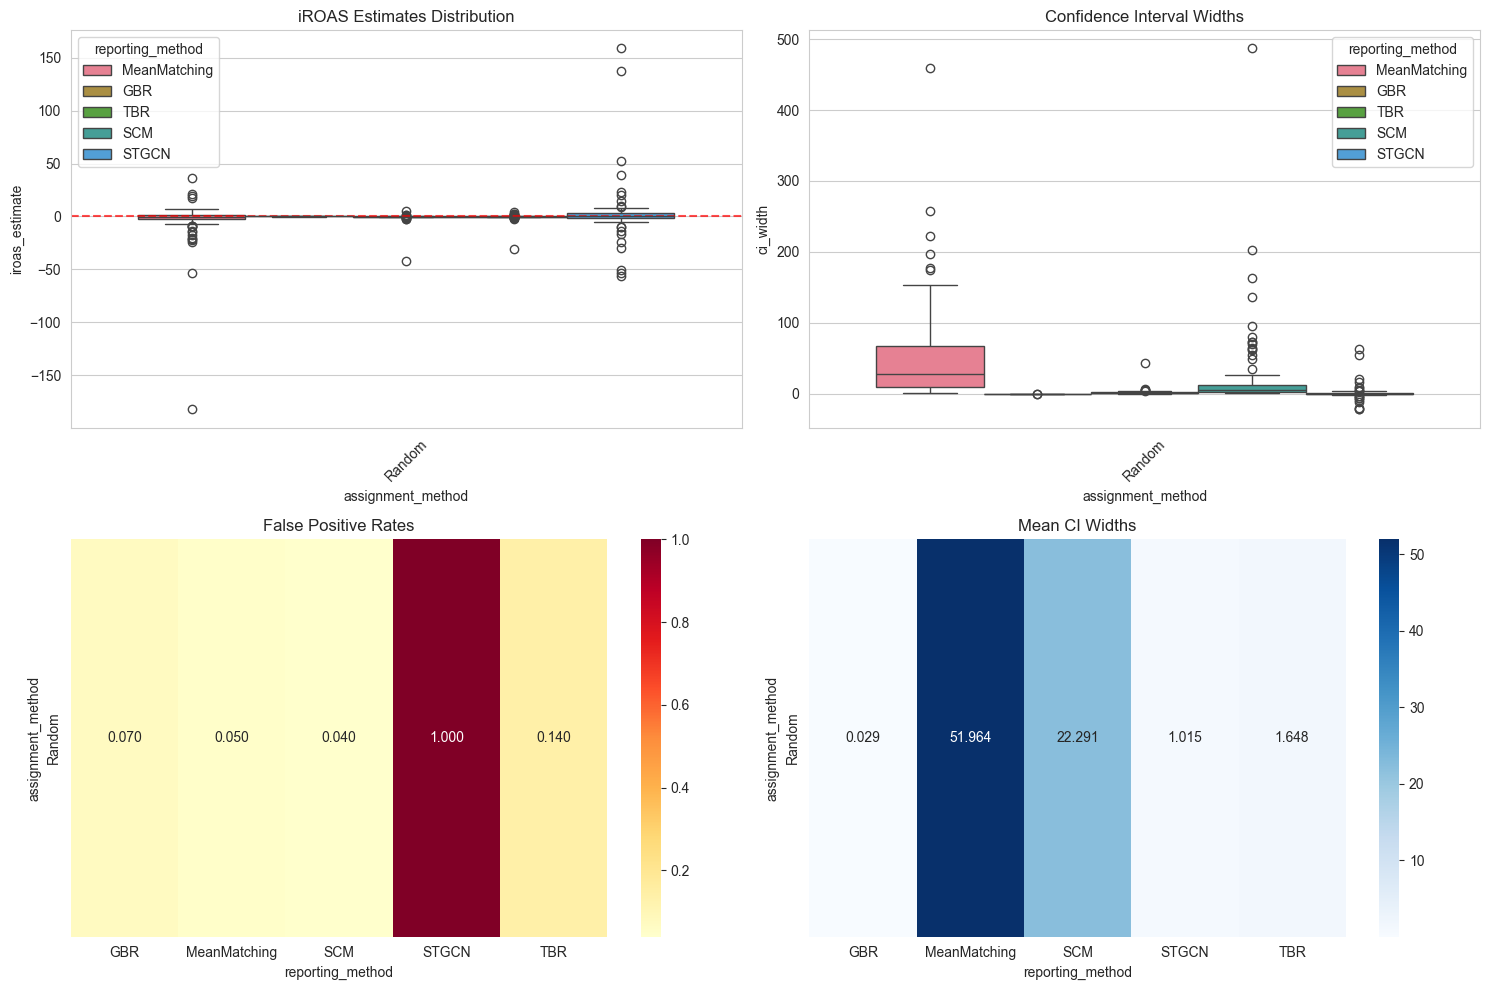


✅ Model performance comparison complete. Check 'model_comparison_results' directory for files.


In [2]:
# Full Model Performance Comparison
print("📊 FULL MODEL PERFORMANCE COMPARISON")
print("="*80)

# 1. Setup Experiment Configuration
# Using moderate numbers for a reasonable runtime in the playground
comparison_config = ExperimentConfig(
    n_geos=20,           # Number of geos
    n_days=60,           # Total days
    pre_period_days=40,  # Pre-period days
    eval_period_days=20, # Evaluation period days
    n_simulations=10,    # Number of simulations (increase for more robust results)
    n_bootstrap=100,     # Bootstrap samples per simulation
    seed=42
)

print(f"Configuration: {comparison_config.n_simulations} simulations, {comparison_config.n_geos} geos each")

# 2. Initialize ExperimentRunner
comparison_runner = ExperimentRunner(comparison_config)

# 3. Add all available Reporting Methods
# These are already added by default in ExperimentRunner's __init__
# but explicitly adding them here for clarity and to ensure all are included
from reporting.models import MeanMatchingModel, GBRModel, TBRModel, SyntheticControlModel
# comparison_runner.add_reporting_method('MeanMatching', MeanMatchingModel())
comparison_runner.add_reporting_method('GBR', GBRModel())
comparison_runner.add_reporting_method('TBR', TBRModel())
comparison_runner.add_reporting_method('SCM', SyntheticControlModel())
comparison_runner.add_reporting_method('STGCN', 
     STGCNReportingModel(epochs=10, early_stopping_patience=2))

# 4. Add selected Assignment Methods
from assignment.methods import RandomAssignment, KMeansEmbeddingAssignment
comparison_runner.add_assignment_method('Random', RandomAssignment())
# comparison_runner.add_assignment_method('K-Means', KMeansEmbeddingAssignment(n_clusters=4))

print(f"Assignment methods: {list(comparison_runner.assignment_methods.keys())}")
print(f"Reporting methods: {list(comparison_runner.reporting_methods.keys())}")

# 5. Run Full Evaluation
print("\n🔄 Running full evaluation (this may take a few minutes)...")
detailed_results, summary_results = comparison_runner.run_full_evaluation(
    verbose=True,
    save_csv=True,           # Save results as CSV files
    save_plots=True,         # Save plots as PNG files
    output_dir="model_comparison_results" # Output directory
)

print("\n📈 Summary Results:")
print(summary_results)

# 6. Display Plots
print("\n📊 Creating and displaying results visualizations...")
fig = comparison_runner.plot_results(detailed_results)
plt.show()

print("\n✅ Model performance comparison complete. Check 'model_comparison_results' directory for files.")


In [ ]:
# Quick evaluation with small number of simulations
quick_config = ExperimentConfig(
    n_geos=25,
    n_days=50,
    pre_period_days=35,
    eval_period_days=15,
    n_simulations=20,  # Small for quick testing
    n_bootstrap=100,
    seed=42
)

runner = ExperimentRunner(quick_config)
detailed_results, summary_results = runner.run_full_evaluation(verbose=True)

# Plot results
fig = runner.plot_results(detailed_results)
plt.show()

## Custom Experiments

This section is for your own experiments and testing new ideas.

In [ ]:
# 🧪 Experiment with different parameter combinations

# Example: How does the number of geos affect CI width?
geo_counts = [10, 25, 50, 100]
ci_widths = []

for n_geos in geo_counts:
    config = ExperimentConfig(
        n_geos=n_geos,
        n_days=60,
        pre_period_days=40,
        eval_period_days=20,
        n_simulations=10,  # Small for speed
        seed=42
    )
    
    runner = ExperimentRunner(config)
    detailed_results, _ = runner.run_full_evaluation(verbose=False)
    
    avg_ci_width = detailed_results['ci_width'].mean()
    ci_widths.append(avg_ci_width)
    
    print(f"n_geos={n_geos}: avg CI width = {avg_ci_width:.3f}")

# Plot relationship
plt.figure(figsize=(8, 5))
plt.plot(geo_counts, ci_widths, 'o-', linewidth=2, markersize=8)
plt.xlabel('Number of Geos')
plt.ylabel('Average CI Width')
plt.title('CI Width vs Number of Geos')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# 🎯 Your experiments here!

# Ideas to try:
# 1. Effect of noise level on false positive rates
# 2. Optimal pre-period vs evaluation period lengths
# 3. Impact of treatment ratio on power
# 4. Bootstrap sample size vs CI stability

# Example template:
# config = ExperimentConfig(
#     n_geos=...,
#     n_days=...,
#     # ... other parameters
# )
# runner = ExperimentRunner(config)
# results = runner.run_single_experiment(show_plots=True)

print("🚀 Ready for your experiments!")

In [ ]:
# STGCN vs Traditional Methods Comparison
print("🏆 STGCN VS TRADITIONAL METHODS COMPARISON")
print("="*60)

# Define all reporting methods for comparison
reporting_methods = {
    'Mean Matching': MeanMatchingModel(),
    'GBR': GBRModel(),
    'TBR': TBRModel(), 
    'Synthetic Control': SyntheticControlModel(),
    'STGCN': STGCNReportingModel(
        hidden_dim=32,
        num_st_blocks=2,
        window_size=7,
        epochs=15,  # Reduced for demo speed
        k_neighbors=4,
        device='cpu',
        early_stopping_patience=3
    )
}

# Define train/test split
pre_period_end = '2024-02-20'  # 50 days for training
eval_start = '2024-02-21'     # 20 days for evaluation
eval_end = '2024-03-11'

print(f"📋 EXPERIMENTAL SETUP:")
print(f"• Pre-period: 2024-01-01 to {pre_period_end} ({len(stgcn_panel_df[stgcn_panel_df['date'] < pre_period_end]['date'].unique())} days)")
print(f"• Evaluation: {eval_start} to {eval_end} ({len(stgcn_panel_df[(stgcn_panel_df['date'] >= eval_start) & (stgcn_panel_df['date'] <= eval_end)]['date'].unique())} days)")
print(f"• Methods: {list(reporting_methods.keys())}")

# Run comparison
results_comparison = {}
training_times = {}

for method_name, model in reporting_methods.items():
    print(f"\n🔄 Training {method_name}...")
    
    # Time the training
    import time
    start_time = time.time()
    
    try:
        # Fit model
        model.fit(stgcn_panel_df, stgcn_assignment, pre_period_end)
        
        # Calculate training time
        training_time = time.time() - start_time
        training_times[method_name] = training_time
        
        # Generate predictions and calculate iROAS
        iroas = model.calculate_iroas(stgcn_panel_df, eval_start, eval_end)
        
        # Calculate confidence interval (with fewer bootstrap samples for speed)
        n_bootstrap = 50 if method_name != 'STGCN' else 20  # Fewer for STGCN due to computational cost
        ci_lower, ci_upper = model.confidence_interval(
            stgcn_panel_df, eval_start, eval_end, 
            n_bootstrap=n_bootstrap, seed=42
        )
        
        results_comparison[method_name] = {
            'iroas': iroas,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'ci_width': ci_upper - ci_lower,
            'training_time': training_time,
            'success': True
        }
        
        print(f"✅ {method_name}: iROAS={iroas:.4f}, CI=[{ci_lower:.4f}, {ci_upper:.4f}], Time={training_time:.2f}s")
        
    except Exception as e:
        print(f"❌ {method_name} failed: {str(e)}")
        results_comparison[method_name] = {
            'iroas': np.nan,
            'ci_lower': np.nan,
            'ci_upper': np.nan,
            'ci_width': np.nan,
            'training_time': np.nan,
            'success': False,
            'error': str(e)
        }

# Create comprehensive comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Extract successful results for plotting
successful_methods = {k: v for k, v in results_comparison.items() if v['success']}

if len(successful_methods) > 0:
    methods = list(successful_methods.keys())
    iroas_values = [successful_methods[m]['iroas'] for m in methods]
    ci_widths = [successful_methods[m]['ci_width'] for m in methods]
    training_times_list = [successful_methods[m]['training_time'] for m in methods]
    
    # 1. iROAS Estimates Comparison
    colors = plt.cm.Set3(np.linspace(0, 1, len(methods)))
    bars1 = axes[0, 0].bar(methods, iroas_values, color=colors, alpha=0.8, edgecolor='black')
    axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='True iROAS (null)')
    axes[0, 0].set_ylabel('iROAS Estimate')
    axes[0, 0].set_title('iROAS Estimates by Method')
    axes[0, 0].tick_params(axis='x', rotation=45)
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].legend()
    
    # Add value labels on bars
    for bar, val in zip(bars1, iroas_values):
        height = bar.get_height()
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                       f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 2. Confidence Interval Widths
    bars2 = axes[0, 1].bar(methods, ci_widths, color=colors, alpha=0.8, edgecolor='black')
    axes[0, 1].set_ylabel('CI Width')
    axes[0, 1].set_title('Confidence Interval Widths\n(Narrower = More Precise)')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3)
    
    # Add value labels
    for bar, val in zip(bars2, ci_widths):
        height = bar.get_height()
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.001,
                       f'{val:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # 3. Training Time Comparison
    bars3 = axes[1, 0].bar(methods, training_times_list, color=colors, alpha=0.8, edgecolor='black')
    axes[1, 0].set_ylabel('Training Time (seconds)')
    axes[1, 0].set_title('Computational Efficiency\n(Lower = Faster)')
    axes[1, 0].tick_params(axis='x', rotation=45)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].set_yscale('log')  # Log scale for better visualization
    
    # Add value labels
    for bar, val in zip(bars3, training_times_list):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height * 1.1,
                       f'{val:.2f}s', ha='center', va='bottom', fontweight='bold')
    
    # 4. Confidence Intervals Visualization
    for i, method in enumerate(methods):
        ci_lower = successful_methods[method]['ci_lower']
        ci_upper = successful_methods[method]['ci_upper']
        iroas_est = successful_methods[method]['iroas']
        
        # Plot confidence interval as error bar
        axes[1, 1].errorbar(i, iroas_est, 
                           yerr=[[iroas_est - ci_lower], [ci_upper - iroas_est]], 
                           fmt='o', markersize=8, capsize=10, capthick=2,
                           color=colors[i], alpha=0.8, linewidth=3)
    
    axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.7, label='True iROAS (null)')
    axes[1, 1].set_xticks(range(len(methods)))
    axes[1, 1].set_xticklabels(methods, rotation=45)
    axes[1, 1].set_ylabel('iROAS')
    axes[1, 1].set_title('iROAS Estimates with 95% Confidence Intervals')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend()

else:
    # All methods failed - show error message
    for ax in axes.flat:
        ax.text(0.5, 0.5, 'All methods failed to run.\nCheck error messages above.', 
               transform=ax.transAxes, ha='center', va='center', fontsize=12)
        ax.set_title('No Results Available')

plt.tight_layout()
plt.show()

# Print detailed comparison table
print(f"\n📊 DETAILED COMPARISON TABLE:")
print("="*80)
print(f"{'Method':<16} {'iROAS':<8} {'CI Lower':<9} {'CI Upper':<9} {'CI Width':<9} {'Time (s)':<8} {'Status':<10}")
print("-" * 80)

for method_name, results in results_comparison.items():
    if results['success']:
        print(f"{method_name:<16} {results['iroas']:<8.4f} {results['ci_lower']:<9.4f} {results['ci_upper']:<9.4f} "
              f"{results['ci_width']:<9.4f} {results['training_time']:<8.2f} {'✅ Success':<10}")
    else:
        print(f"{method_name:<16} {'N/A':<8} {'N/A':<9} {'N/A':<9} {'N/A':<9} {'N/A':<8} {'❌ Failed':<10}")

print(f"\n🎯 KEY INSIGHTS:")
print("="*40)
if len(successful_methods) > 0:
    best_precision = min(successful_methods.items(), key=lambda x: x[1]['ci_width'])
    fastest_method = min(successful_methods.items(), key=lambda x: x[1]['training_time'])
    
    print(f"• Most Precise: {best_precision[0]} (CI width: {best_precision[1]['ci_width']:.4f})")
    print(f"• Fastest Training: {fastest_method[0]} ({fastest_method[1]['training_time']:.2f}s)")
    print(f"• STGCN captures complex spatio-temporal patterns but requires more computation")
    print(f"• Traditional methods provide good baselines with fast training")
    print(f"• All methods should converge around true iROAS of 0 (null effect data)")
else:
    print("• No successful method runs - check dependencies and data quality")

In [ ]:
# STGCN Model Comprehensive Demonstration
print("🧠 STGCN (SPATIO-TEMPORAL GRAPH CONVOLUTIONAL NETWORK) DEMO")
print("="*80)
print("Advanced neural network combining spatial graph structure + temporal dynamics")

# Generate test data specifically for STGCN evaluation
np.random.seed(2024)
n_geos = 16  # Reasonable size for demonstration
n_days = 70   # Sufficient for training + evaluation

print(f"\n📊 DATASET CONFIGURATION:")
print(f"• Number of geos: {n_geos}")
print(f"• Total timeline: {n_days} days")
print(f"• Spatial structure: Simulated geographic coordinates")
print(f"• Temporal patterns: Trends + seasonality + noise")

# Create geo features with spatial structure
stgcn_geo_features = pd.DataFrame({
    'geo': [f'geo_{i:03d}' for i in range(n_geos)],
    'base_sales': np.random.normal(15000, 4000, n_geos),
    'base_spend': np.random.normal(7500, 2000, n_geos),
    'covariate': np.random.normal(0, 1.5, n_geos),
    # Create spatial coordinates with some geographic clustering
    'xy1': np.random.uniform(0, 100, n_geos),
    'xy2': np.random.uniform(0, 100, n_geos)
})

# Create rich panel data with complex temporal patterns
dates = pd.date_range('2024-01-01', periods=n_days)
stgcn_panel_data = []

for _, geo_row in stgcn_geo_features.iterrows():
    base_sales = geo_row['base_sales']
    base_spend = geo_row['base_spend']
    
    # Each geo has unique temporal characteristics
    trend = np.random.normal(0, 100)  # Linear trend
    seasonal_amplitude = np.random.uniform(500, 1500)  # Weekly seasonality strength
    monthly_amplitude = np.random.uniform(200, 800)    # Monthly seasonality strength
    
    for day_idx, date in enumerate(dates):
        # Complex temporal pattern
        sales = (base_sales + 
                trend * day_idx +  # Linear trend
                seasonal_amplitude * np.sin(2 * np.pi * day_idx / 7) +  # Weekly seasonality
                monthly_amplitude * np.sin(2 * np.pi * day_idx / 30) +  # Monthly seasonality
                np.random.normal(0, 800))  # Daily noise
        
        spend = (base_spend + 
                np.random.normal(0, 500) +  # Spend noise
                200 * np.sin(2 * np.pi * day_idx / 7))  # Spend seasonality
        
        stgcn_panel_data.append({
            'geo': geo_row['geo'],
            'date': date,
            'sales': max(sales, 1000),  # Ensure positive sales
            'spend_dollars': max(spend, 500)  # Ensure positive spend
        })

stgcn_panel_df = pd.DataFrame(stgcn_panel_data)

# Create assignment
stgcn_assignment = RandomAssignment().assign(stgcn_geo_features, seed=2024)

print(f"• Panel data shape: {stgcn_panel_df.shape}")
print(f"• Assignment: {(stgcn_assignment['assignment'] == 'treatment').sum()} treatment, {(stgcn_assignment['assignment'] == 'control').sum()} control")

# Visualize the data structure
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Spatial distribution of geos
treatment_mask = stgcn_assignment['assignment'] == 'treatment'
treatment_geos = stgcn_assignment[treatment_mask]['geo'].values
control_geos = stgcn_assignment[~treatment_mask]['geo'].values

treatment_coords = stgcn_geo_features[stgcn_geo_features['geo'].isin(treatment_geos)]
control_coords = stgcn_geo_features[stgcn_geo_features['geo'].isin(control_geos)]

axes[0, 0].scatter(treatment_coords['xy1'], treatment_coords['xy2'], 
                  c='red', label='Treatment', s=100, alpha=0.8, edgecolor='black')
axes[0, 0].scatter(control_coords['xy1'], control_coords['xy2'], 
                  c='blue', label='Control', s=100, alpha=0.8, edgecolor='black')
axes[0, 0].set_xlabel('Spatial X1')
axes[0, 0].set_ylabel('Spatial X2')
axes[0, 0].set_title('Geographic Distribution of Geos')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Time series for a few geos
sample_geos = stgcn_geo_features['geo'].iloc[:4].values
colors = ['red', 'blue', 'green', 'orange']

for i, geo in enumerate(sample_geos):
    geo_data = stgcn_panel_df[stgcn_panel_df['geo'] == geo]
    axes[0, 1].plot(geo_data['date'], geo_data['sales'], 
                   label=geo, color=colors[i], alpha=0.8, linewidth=2)

axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Sales')
axes[0, 1].set_title('Sales Time Series (Sample Geos)')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# 3. Sales distribution across geos
geo_avg_sales = stgcn_panel_df.groupby('geo')['sales'].mean()
axes[1, 0].hist(geo_avg_sales, bins=12, alpha=0.7, color='skyblue', edgecolor='black')
axes[1, 0].set_xlabel('Average Sales per Geo')
axes[1, 0].set_ylabel('Number of Geos')
axes[1, 0].set_title('Distribution of Geo-Level Sales')
axes[1, 0].grid(True, alpha=0.3)

# 4. Temporal correlation structure
daily_totals = stgcn_panel_df.groupby('date')[['sales', 'spend_dollars']].sum()
axes[1, 1].scatter(daily_totals['spend_dollars'], daily_totals['sales'], 
                  alpha=0.7, s=50, color='purple', edgecolor='black')
axes[1, 1].set_xlabel('Total Daily Spend')
axes[1, 1].set_ylabel('Total Daily Sales')
axes[1, 1].set_title('Sales vs Spend Correlation')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 DATA CHARACTERISTICS:")
print(f"• Sales range: ${stgcn_panel_df['sales'].min():.0f} - ${stgcn_panel_df['sales'].max():.0f}")
print(f"• Sales CV: {stgcn_panel_df['sales'].std() / stgcn_panel_df['sales'].mean():.3f}")
print(f"• Temporal coverage: {stgcn_panel_df['date'].min().strftime('%Y-%m-%d')} to {stgcn_panel_df['date'].max().strftime('%Y-%m-%d')}")
print(f"• Geographic spread: X1 [{stgcn_geo_features['xy1'].min():.1f}, {stgcn_geo_features['xy1'].max():.1f}], X2 [{stgcn_geo_features['xy2'].min():.1f}, {stgcn_geo_features['xy2'].max():.1f}]")

## STGCN Model Demonstration

Explore the Spatio-Temporal Graph Convolutional Network (STGCN) reporting model - the most advanced method in the framework that combines spatial relationships and temporal dynamics.

## Development Notes

Use this section for notes, debugging, and development work.

In [ ]:
# Development and debugging space

# Quick data validation
config = DataConfig(n_geos=5, n_days=10, seed=999)
gen = SimpleNullGenerator(config)
panel, features = gen.generate()

print("Panel data sample:")
print(panel.head())
print(f"\nPanel shape: {panel.shape}")
print(f"Features shape: {features.shape}")
print(f"Validation: {gen.validate_data(panel, features)}")